In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install chart_studio
#from chart_studio.plotly import plot, iplot
from plotly.offline import iplot
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 5.3 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
train_data = pd.read_csv(r'/content/drive/MyDrive/Assignments/Case_study_1/train.csv/train.csv')
test_data = pd.read_csv(r'/content/drive/MyDrive/Assignments/Case_study_1/test.csv/test.csv')

In [5]:
print('Null values in VisitNumber field', train_data['VisitNumber'].isnull().sum())
print('Null values in Weekday field' ,train_data['Weekday'].isnull().sum())
print('Null values in Upc field' ,train_data['Upc'].isnull().sum())
print('Null values in DepartmentDescription field' ,train_data['DepartmentDescription'].isnull().sum())
print('Null values in FinelineNumber field' ,train_data['FinelineNumber'].isnull().sum())
print('Null values in ScanCount field' ,train_data['ScanCount'].isnull().sum())

Null values in VisitNumber field 0
Null values in Weekday field 0
Null values in Upc field 4129
Null values in DepartmentDescription field 1361
Null values in FinelineNumber field 4129
Null values in ScanCount field 0


In [ ]:
def pre_process(train_data):
  # Dropping the duplicate values
  preprocessed_train =  pd.DataFrame()
  train_data = train_data.drop_duplicates()
  # Replacing the missing values with appropriate stastic
  train_data['FinelineNumber'] = train_data['FinelineNumber'].fillna(train_data['FinelineNumber'].mode()[0], inplace = True)
  train_data['Upc'] = train_data['Upc'].fillna(train_data['Upc'].mode()[0], inplace = True)
  train_data['DepartmentDescription'] = train_data['DepartmentDescription'].fillna('OTHER DEPARTMENTS', inplace = True)
  #Created a new column 'Return' which marks as 1 if scan count is negative
  train_data['Return'] = train_data['ScanCount']
  train_data.loc[train_data['ScanCount'] > 0, 'Return'] = 0
  train_data.loc[train_data['ScanCount'] < 0, 'Return'] = 1

  # Here in DepartmentDescription we are combining the categories of similar type, this will make the categories with less count fall under one major category. 

  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("MENSWEAR", "MENS WEAR"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("LADIES SOCKS", "LADIESWEAR"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("PLUS AND MATERNITY", "LADIESWEAR"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("BRAS & SHAPEWEAR", "LADIESWEAR"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("PHARMACY RX", "PHARMACY"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("HEALTH AND BEAUTY AIDS", "PHARMACY"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("INFANT CONSUMABLE HARD LINES", "INFANT SECTION"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("INFANT APPAREL", "INFANT SECTION"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("OPTICAL - FRAMES", "OPTICALS"))
  train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: x.replace("OPTICAL - LENSES", "OPTICALS"))

  # Now applying the pd.get_dummies on DepartmentDescription and weekday columns
  dept = pd.get_dummies(train_data[['DepartmentDescription']])
  train_data  = pd.concat([train_data, dept],axis = 1 )

  day_number = pd.get_dummies(train_data['Weekday'])
  train_data  = pd.concat([train_data, day_number],axis = 1 )

  dept_feature = []

  # Aggregating based on VisitNumber for all the columns 
  #https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm
  Upc = train_data.groupby(['VisitNumber'])['Upc'].count()
  preprocessed_train['Upc'] = Upc
  FinelineNumber = train_data.groupby(['VisitNumber'])['FinelineNumber'].count()
  preprocessed_train['FinelineNumber'] = FinelineNumber
  Return = train_data.groupby(['VisitNumber'])['Return'].max()
  preprocessed_train['Return'] = Return
  Weekday = train_data.groupby(['VisitNumber'])['Weekday'].max()
  preprocessed_train['Weekday'] = Weekday
  TripType = train_data.groupby(['VisitNumber'])['TripType'].max()
  preprocessed_train['TripType'] = TripType
  ScanCount = train_data.groupby(['VisitNumber'])['ScanCount'].max()
  preprocessed_train['ScanCount'] = ScanCount
  # Iterating through dept description columns and grouping by based on Visit number
  for i in list(dept.columns):
    dept_feature.append(i)
  
  for j in dept_feature:
    preprocessed_train[j] = train_data.groupby(['VisitNumber'])[j].sum()

  
  # train['DepartmentDescription_1-HR PHOTO'] = train.groupby(['VisitNumber'])['DepartmentDescription_1-HR PHOTO'].sum()
  # train['DepartmentDescription_ACCESSORIES'] = train.groupby(['VisitNumber'])['DepartmentDescription_ACCESSORIES'].sum()
  # train['DepartmentDescription_AUTOMOTIVE'] = train.groupby(['VisitNumber'])['DepartmentDescription_AUTOMOTIVE'].sum()
  # train['DepartmentDescription_BAKERY'] = train.groupby(['VisitNumber'])['DepartmentDescription_BAKERY'].sum()
  # train['DepartmentDescription_BATH AND SHOWER'] = train.groupby(['VisitNumber'])['DepartmentDescription_BATH AND SHOWER'].sum()
  # train['DepartmentDescription_BEAUTY'] = train.groupby(['VisitNumber'])['DepartmentDescription_BEAUTY'].sum()
  # train['DepartmentDescription_BEDDING'] = train.groupby(['VisitNumber'])['DepartmentDescription_BEDDING'].sum()
  # train['DepartmentDescription_BEDDING'] = train.groupby(['VisitNumber'])['DepartmentDescription_BEDDING'].sum()

  return preprocessed_train
  



We can observe from above plot that there are few categories which can be combined, which fall under similar catgeory but are present separately, so we will rename few columns with one column falling in that category.
For eg., MENS WEAR and MENSWEAR; LADIESWEAR and (LADIES SOCKS, PLUS AND MATERNITY, BRAS & SHAPEWEAR); PHARMACY OTC and (PHARMACY RX, HEALTH AND BEAUTY AIDS); COMM BREAD AND BAKERY; INFANT CONSUMABLE HARD LINES and INFANT APPAREL; OPTICAL - FRAMES and OPTICAL - LENSES. This all we will be doing as part of feature engineering. In this way we can club together fields with lesser count and reduce the dimensions.
Before we perform the pd.get_dummies() on department description.

We can see above few of the departments are having very less count like SHEER HOSIERY, 
and also as a category, they are not similar to the other major categories

In [6]:
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("MENSWEAR", "MENS WEAR"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("LADIES SOCKS", "LADIESWEAR"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("PLUS AND MATERNITY", "LADIESWEAR"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("BRAS & SHAPEWEAR", "LADIESWEAR"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("PHARMACY RX", "PHARMACY"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("PHARMACY OTC", "PHARMACY"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("HEALTH AND BEAUTY AIDS", "PHARMACY"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("INFANT CONSUMABLE HARD LINES", "INFANT SECTION"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("INFANT APPAREL", "INFANT SECTION"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("OPTICAL - FRAMES", "OPTICALS"))
train_data["DepartmentDescription"] = train_data["DepartmentDescription"].apply(lambda x: str(x).replace("OPTICAL - LENSES", "OPTICALS"))

In [7]:
dept = pd.get_dummies(train_data[['DepartmentDescription']])
train_data  = pd.concat([train_data, dept],axis = 1 )

In [8]:
dept_feature = []
for i in list(pd.get_dummies(train_data[['DepartmentDescription']]).columns):
  dept_feature.append(i)

In [22]:
train_data = pd.DataFrame()

In [11]:
for j in dept_feature:
  train_data[j] = train_data.groupby(['VisitNumber'])[j].sum()

In [16]:
Upc = train_data.groupby(['VisitNumber'])['Upc'].count()
train_data['Upc'] = Upc
FinelineNumber = train_data.groupby(['VisitNumber'])['FinelineNumber'].count()
train_data['FinelineNumber'] = FinelineNumber
Return = train_data.groupby(['VisitNumber'])['Return'].max()
train_data['Return'] = Return
Weekday = train_data.groupby(['VisitNumber'])['Weekday'].max()
train_data['Weekday'] = Weekday
TripType = train_data.groupby(['VisitNumber'])['TripType'].max()
train_data['TripType'] = TripType
ScanCount = train_data.groupby(['VisitNumber'])['ScanCount'].max()
train_data['ScanCount'] = ScanCount

In [18]:
train_data.head(2)

,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_CAMERAS AND SUPPLIES,...,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan,Upc,FinelineNumber,Return,Weekday,TripType,ScanCount
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,Friday,999,-1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,2,0,Friday,30,1


**Outlier detection:**

Text(0.5, 1.0, 'VisitNumber hist- train data')

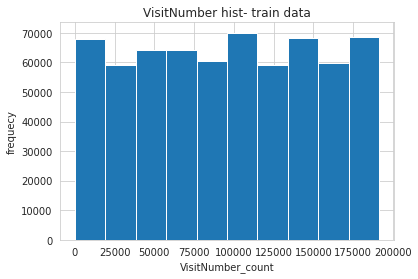

In [ ]:
ax = train_data['VisitNumber'].plot.hist()
ax.set_ylabel("frequecy")
ax.set_xlabel("VisitNumber_count")
ax.set_title('VisitNumber hist- train data')

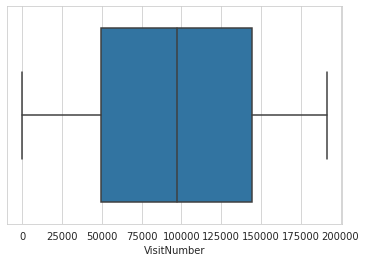

In [ ]:
sns.boxplot(x=train_data['VisitNumber'])

Text(0.5, 1.0, 'VisitNumber hist- test data')

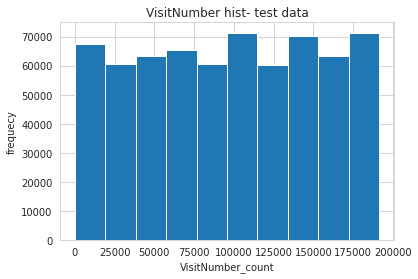

In [ ]:
ax = test_data['VisitNumber'].plot.hist()
ax.set_ylabel("frequecy")
ax.set_xlabel("VisitNumber_count")
ax.set_title('VisitNumber hist- test data')

There's no outlier as such indicated in VisitNumber column.

In [ ]:
data_50K = train_data[:50000]

In [ ]:
z = data_50K['TripType']

In [ ]:
#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50, n_jobs = -1)
data=xtsne.fit_transform(data_50K.drop(['TripType'], axis=1))

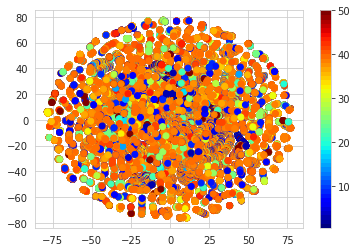

In [ ]:
vis_x = data[:, 0]
vis_y = data[:, 1]
plt.scatter(vis_x, vis_y, c=z, cmap=plt.cm.get_cmap("jet", 50))
plt.colorbar()
plt.clim(0.5, 50)
plt.show()

In [ ]:
xtsne=TSNE(perplexity=30, n_jobs = -1)
data=xtsne.fit_transform(data_50K.drop(['TripType'], axis=1))

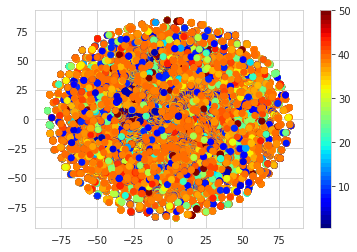

In [ ]:
vis_x = data[:, 0]
vis_y = data[:, 1]
plt.scatter(vis_x, vis_y, c=z, cmap=plt.cm.get_cmap("jet", 50))
plt.colorbar()
plt.clim(0.5, 50)
plt.show()

As observed in the tsne analysis trip type 40 to 45 seems to be a predominant group in the cluster.
However as we could see either with the perplexity of 30 or 50 we are not able to distinguish.